# Running `ImageGraph` on seal impressions
*By Andreas Angourakis (24/06/2021)*

This Jupyter notebook can be run if placed in a root directory with a directory named "input_seals" is added with the corresponding images. Also, make sure to install imagegraph Python library by running the following command in your local terminal:

`!pip install git+https://github.com/leoimpett/pyimagegraph`

Note: dependencies will need to be installed too (e.g., tqdm, scikit-image, sklearn, requests, tensorflow)

## Preparation
### Import modules

In [65]:
from os import listdir
from os.path import isfile, join
import collections
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import statistics

import imagegraph as ig

### Define and set global parameters

In [3]:
# input and output folders
inputDirectory = 'input_seals/'
outputDirectory = 'output_seals/'

### Load images from input directory

In [4]:
imL00 = ig.loadLocalImages(impaths=inputDirectory)

100%|██████████| 684/684 [05:52<00:00,  1.94it/s]


## Calculations
### Get Neural Network embedding (NN)

In [30]:
vL01 = ig.getNNEmbedding(imL00)

Initiating model: vgg16
100%|██████████| 684/684 [02:13<00:00,  5.11it/s]


Write to binary data file:

In [51]:
with open(outputDirectory + "NNE.data", 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(vL01, filehandle)

Read from binary data file:

In [5]:
with open(outputDirectory + "NNE.data", 'rb') as filehandle:
    # read the data as binary data stream
    vL01 = pickle.load(filehandle)

### Calculate distance matrix

In [68]:
m02 = ig.distanceMatrix(vL01,vL01) 

Write to binary data file:

In [69]:
with open(outputDirectory + "distMatrix.data", 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(m02, filehandle)

Read from binary data file:

In [49]:
with open(outputDirectory + "distMatrix.data", 'rb') as filehandle:
    # read the data as binary data stream
    m02 = pickle.load(filehandle)

### Create pairwise dataset (list of tupples)

In [95]:
pairwiseDistances = list()
for i in range(len(imL00)):
    imageName_i = imL00[i]['meta']
    for j in range(len(imL00)):
        if i != j:
            imageName_j = imL00[j]['meta']
            distance_ij = m02[i][j]
            pairwiseDistances.append([imageName_i, imageName_j, distance_ij])

In [96]:
print(str(len(m02)) + ' ' + str(len(imL00)))
print(str(len(m02) * len(m02)))
print(len(pairwiseDistances))
(len(m02) * len(m02)) - len(m02)

684 684
467856
467172


467172

Save it as a csv file:

In [97]:
with open(outputDirectory + "pairwiseDistances.csv", 'w', newline='') as filehandle:
    csv_out = csv.writer(filehandle)
    csv_out.writerow(['image_1', 'image_2', 'distance'])
    csv_out.writerows(pairwiseDistances)

## Visualisations
### Print distance matrix

In [72]:
_ = ig.consolePrint(m02)

[[ 0.         26.08898599 33.88851612 ... 28.22314386 28.88777732
  29.34687341]
 [26.08898599  0.         19.4679666  ... 16.77763405 17.04890455
  18.47804834]
 [33.88851612 19.4679666   0.         ... 19.45770336 20.62711999
  22.52605282]
 ...
 [28.22314386 16.77763405 19.45770336 ...  0.         14.21524912
  15.47705845]
 [28.88777732 17.04890455 20.62711999 ... 14.21524912  0.
  13.75455986]
 [29.34687341 18.47804834 22.52605282 ... 15.47705845 13.75455986
   0.        ]]


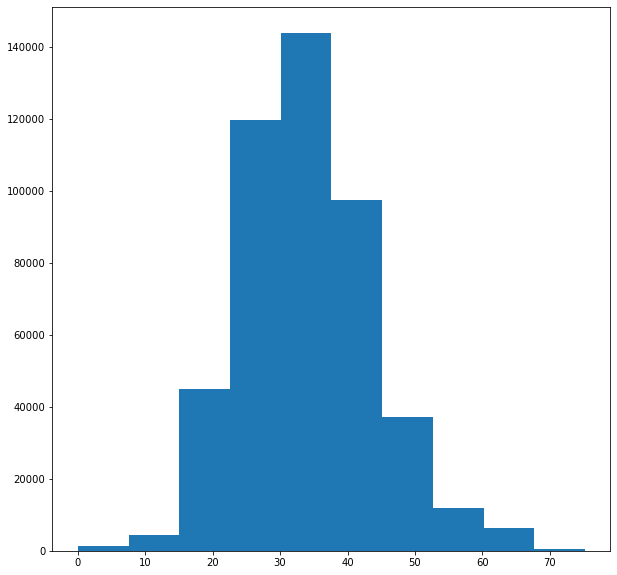

In [73]:
plt.hist(m02.flatten())
plt.show() 

In [77]:
statistics.mean(m02.flatten())

33.93326052645006

### Display NearestNeighbors


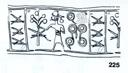
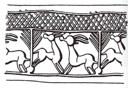
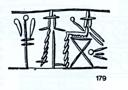
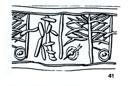
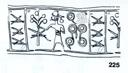
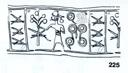
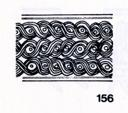
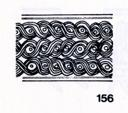
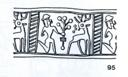
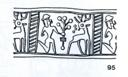
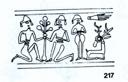
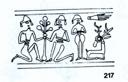
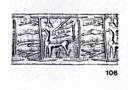
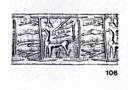
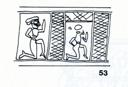
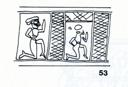
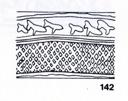
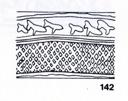
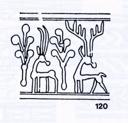
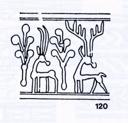
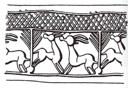
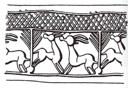
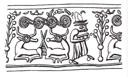
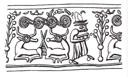
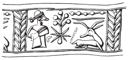
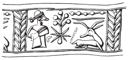
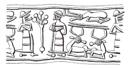
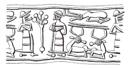
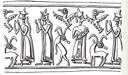
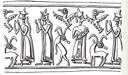
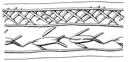
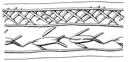
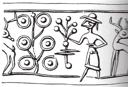
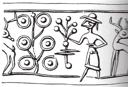
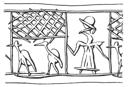
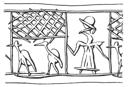
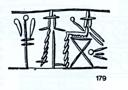
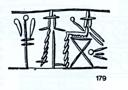
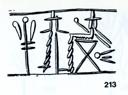
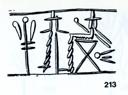
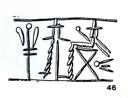
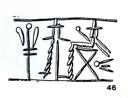
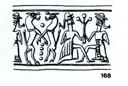
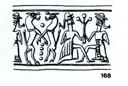
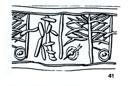
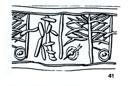
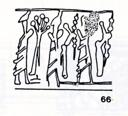
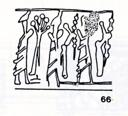
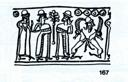
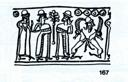
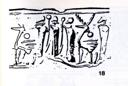
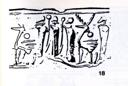
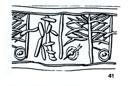
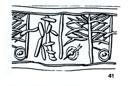
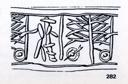
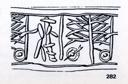
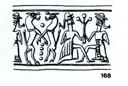
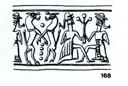
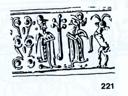
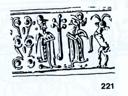
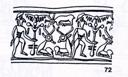
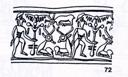
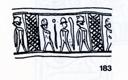
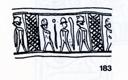
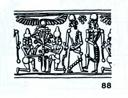
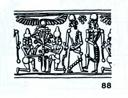
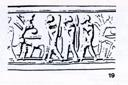
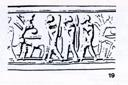

In [10]:
_ = ig.displayNearestNeighbors(imL00,imL00,m02)

### Define `plot_image_pairs_with_distance()`:

In [98]:
def plot_image_pairs_with_distance(imagePairsWithDistances, fontsize_imageName = 10, fontsize_distance = 14, figsize_per_row = (10, 2)):
    # prepare plotting matrix
    ncols = 3
    nrows = len(imagePairsWithDistances)

    plt.rcParams["figure.figsize"] = (figsize_per_row[0], nrows * figsize_per_row[1])
    fig,ax = plt.subplots(nrows = nrows, ncols = ncols)

    # print images
    for i in range(nrows):
        for j in range(ncols):
            if (j == 2):
                ax[i][j].axis([0, 10, 0, 10])
                ax[i][j].text(2, 6, imagePairsWithDistances[i][j], fontsize = fontsize_distance)
            else:
                ax[i][j].set_title(imagePairsWithDistances[i][j].removeprefix(inputDirectory.replace('/', '\\')).removesuffix('.jpg'), fontsize = fontsize_imageName)
                with open(imagePairsWithDistances[i][j], 'rb') as f:
                    image = Image.open(f)
                    ax[i][j].imshow(image)
            ax[i][j].set_axis_off()
    fig.show()

### Display images with least distances:

In [99]:
nearestPairs = tuple(sorted(pairwiseDistances, key=lambda item: item[2], reverse=False))[:5]
nearestPairs

(['input_seals\\Alalah_S002047(d).jpg',
  'input_seals\\Alalah_S002047(d).jpg',
  0.0],
 ['input_seals\\Alalah_S002057(d).jpg',
  'input_seals\\Alalah_S002057(d).jpg',
  0.0],
 ['input_seals\\Alalah_S002058(d).jpg',
  'input_seals\\Alalah_S002058(d).jpg',
  0.0],
 ['input_seals\\Alalah_S002059(d).jpg',
  'input_seals\\Alalah_S002059(d).jpg',
  0.0],
 ['input_seals\\Alalah_S002060(d).jpg',
  'input_seals\\Alalah_S002060(d).jpg',
  0.0])

<ipython-input-58-2039d0a57eed>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


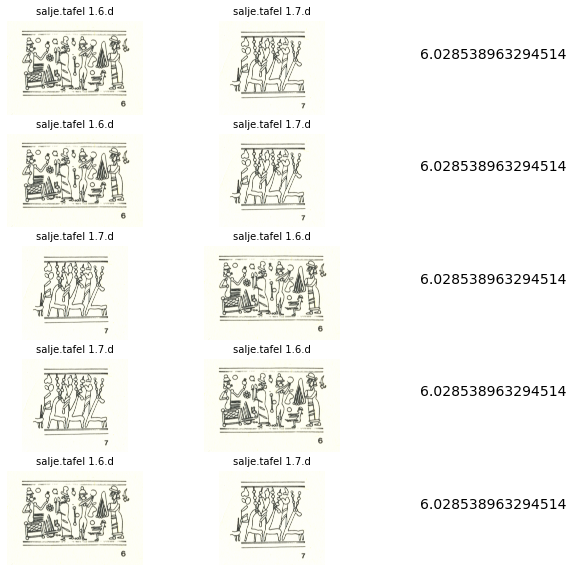

In [81]:
plot_image_pairs_with_distance(nearestPairs)

### Display images with most distances:

In [82]:
fartestPairs = tuple(sorted(pairwiseDistances, key=lambda item: item[2], reverse=True))[:5]
fartestPairs

(['input_seals\\salje.tafel 9.177.d.jpg',
  'input_seals\\Ugarit_S002236(d).jpg',
  75.23108348430895],
 ['input_seals\\salje.tafel 9.177.d.jpg',
  'input_seals\\Ugarit_S002236(d).jpg',
  75.23108348430895],
 ['input_seals\\Ugarit_S002236(d).jpg',
  'input_seals\\salje.tafel 9.177.d.jpg',
  75.23108348430895],
 ['input_seals\\Ugarit_S002236(d).jpg',
  'input_seals\\salje.tafel 9.177.d.jpg',
  75.23108348430895],
 ['input_seals\\salje.tafel 9.177.d.jpg',
  'input_seals\\Ugarit_S002236(d).jpg',
  75.23108348430895])

<ipython-input-58-2039d0a57eed>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


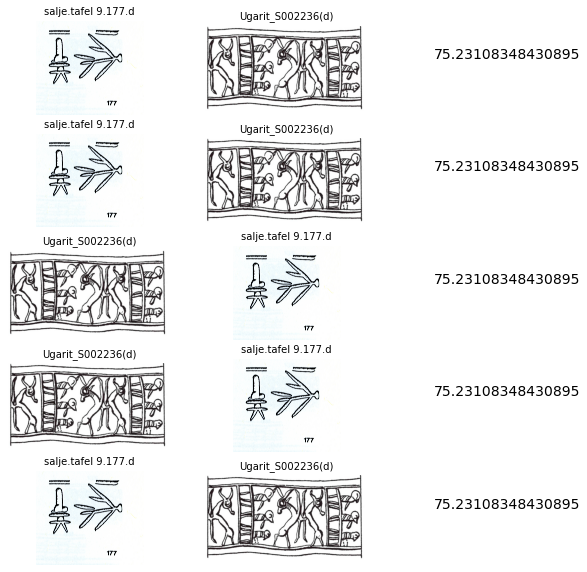

In [83]:
plot_image_pairs_with_distance(fartestPairs)